In [1]:
import numpy as np, pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import r2_score, classification_report



# morgan packages
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

## manipulating the model data

In [2]:
df= pd.read_csv("df_ic50.csv")
print(df.shape)
df.head()

(2952, 46)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,NaN,105376,[],CHEMBL660784,Inhibitory concentration against cyclin-depend...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Cyclin-dependent kinase 2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,36.00
1,NaN,NaN,106512,[],CHEMBL661128,Inhibitory concentration against cyclin-depend...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Cyclin-dependent kinase 2,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,2.00
2,NaN,NaN,107704,[],CHEMBL661128,Inhibitory concentration against cyclin-depend...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Cyclin-dependent kinase 2,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1000.00
3,NaN,NaN,107706,[],CHEMBL661128,Inhibitory concentration against cyclin-depend...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Cyclin-dependent kinase 2,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1000.00
4,NaN,NaN,108039,[],CHEMBL661130,Inhibition of Cyclin-dependent kinase 2,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Cyclin-dependent kinase 2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.03


In [3]:
df.standard_value.isna().sum()

39

In [4]:
#dropping the na values in standard value column
df.dropna(subset=["standard_value"], axis=0, inplace=True)

In [5]:
df.standard_value.isna().sum()

0

In [6]:
df.standard_units.value_counts()

standard_units
nM         2861
ug.mL-1      52
Name: count, dtype: int64

In [7]:
# excluding the ug.mL-1  readings
# df['standard_units2']=np.where (df.standard_type=="ug.mL-1", "NA", "nM")
df=df[df["standard_units"]!= "ug.mL-1"]
df.standard_units.value_counts()

standard_units
nM    2861
Name: count, dtype: int64

In [8]:
#selectiong the 10 nM as a cutoff point
df["activity"]=np.where(df["standard_value"]<=10, 0, 1)
df.activity.value_counts()

activity
1    2468
0     393
Name: count, dtype: int64

In [9]:
type(df.canonical_smiles)

pandas.core.series.Series

In [10]:
def create_molecule(smiles_string):
  try:
    return Chem.MolFromSmiles(smiles_string)
  except:
    return None  # Handle cases where SMILES string is invalid

# Apply the function with error handling
df["Molecule"] = df["canonical_smiles"].apply(create_molecule)
df = df[df['Molecule'].notnull()]  # Keep rows with valid molecules


In [11]:
# df["Molecule"]=df["canonical_smiles"].apply(Chem.MolFromSmiles)
df["Fingerprint"]=df["Molecule"].apply(lambda x:AllChem.GetMorganFingerprintAsBitVect(x,2))

In [12]:
df.Fingerprint


0       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
4       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
2947    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
2948    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2949    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
2950    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
2951    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
Name: Fingerprint, Length: 2857, dtype: object

## designing the model

In [13]:
df.activity.value_counts()

activity
1    2464
0     393
Name: count, dtype: int64

In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    list(df['Fingerprint']),
    df['activity'],
    test_size=0.3,
    random_state=42
)


In [15]:
# # Training the models
# models={
#     "lr":LogisticRegression(C=1),
#     "svc":SVC(),
#     "DTC":DecisionTreeClassifier(),
#     "RFC":RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42),
#     "GBC":GradientBoostingClassifier()
# }


# for names, model in models.items():
#     model.fit(X_train, y_train)
#     Y_pred= model.predict(X_test)
#     print(classification_report(Y_pred, y_test)+names)

In [16]:
# considering the RFC as the best model
model=RandomForestClassifier(max_depth=30, min_samples_split=2, n_estimators=61, min_samples_leaf=1, random_state=123)
model.fit(X_train, y_train)

y_predict=model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74        99
           1       0.97      0.96      0.96       759

    accuracy                           0.94       858
   macro avg       0.84      0.87      0.85       858
weighted avg       0.94      0.94      0.94       858



## preparing all of the pbuchem compounds using our model

In [17]:
df_pubchem= pd.read_csv("all_active_3cols.csv")
df_pubchem.shape

(3106, 3)

In [18]:
df_pubchem.head()

,cid,cmpdname,canonicalsmiles
0,1605,"11,25-Dihydroxy-3-methoxy-2-methyl-4-(methylam...",CC12C(C(CC(O1)N3C4=C(C=C(C=C4)O)C5=C6C(=C7C8=C...
1,3543,2-[trans-(4-Aminocyclohexyl)amino]-6-(benzyl-a...,C1CCC(C1)N2C=NC3=C(N=C(N=C32)NC4CCC(CC4)N)NCC5...
2,4566,O6-Cyclohexylmethoxy-2-(4'-sulphamoylanilino) ...,C1CCC(CC1)COC2=NC(=NC3=C2NC=N3)NC4=CC=C(C=C4)S...
3,5279,Staurosporine HCl,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...
4,44259,Staurosporine,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...


In [19]:
df_pubchem=df_pubchem.drop_duplicates(subset=" cid")
df_pubchem.shape

(3106, 3)

In [20]:
# df_active=pd.read_csv("")

In [21]:
df_pubchem.columns

Index([' cid', 'cmpdname', 'canonicalsmiles'], dtype='object')

In [22]:
df_pubchem.columns=[x.lower().strip() for x in df_pubchem.columns]

In [23]:
df_pubchem.canonicalsmiles.isna().sum()

0

In [24]:
# #creating the Mol from smiles
def create_molecule(smiles_string):
  try:
    return Chem.MolFromSmiles(smiles_string)
  except:
    return None  # Handle cases where SMILES string is invalid

# Apply the function with error handling
df_pubchem["Molecule"] = df_pubchem["canonicalsmiles"].apply(create_molecule)

[14:12:22] WARNING: not removing hydrogen atom without neighbors
[14:12:22] WARNING: not removing hydrogen atom without neighbors
[14:12:22] WARNING: not removing hydrogen atom without neighbors
[14:12:22] WARNING: not removing hydrogen atom without neighbors
[14:12:22] WARNING: not removing hydrogen atom without neighbors


In [25]:
df_pubchem = df_pubchem[df_pubchem['Molecule'].notnull()]  # Keep rows with valid molecules


In [26]:
# #creating the morgan fingerprint column
df_pubchem["Fingerprint"]=df_pubchem["Molecule"].apply(lambda x:AllChem.GetMorganFingerprintAsBitVect(x,2))


In [27]:
#predicting the activity
df_pubchem["predicted"]=model.predict(list(df_pubchem["Fingerprint"]))
#extracting the active probability
active_class = 0

# Get predicted probabilities
predicted_proba = model.predict_proba(list(df_pubchem["Fingerprint"]))

# Extract probabilities for the active class
df_pubchem["predicted_proba"] = predicted_proba[:, active_class]

In [28]:
print(df_pubchem.predicted_proba.value_counts( ascending=True))# all of them are active
df_pubchem.head()

predicted_proba
0.651991     1
0.555001     1
0.518553     1
0.574146     1
0.590772     1
            ..
0.836066    34
0.529169    39
0.508237    47
0.512776    50
0.868852    71
Name: count, Length: 1239, dtype: int64


,cid,cmpdname,canonicalsmiles,Molecule,Fingerprint,predicted,predicted_proba
0,1605,"11,25-Dihydroxy-3-methoxy-2-methyl-4-(methylam...",CC12C(C(CC(O1)N3C4=C(C=C(C=C4)O)C5=C6C(=C7C8=C...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb78b0>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.645129
1,3543,2-[trans-(4-Aminocyclohexyl)amino]-6-(benzyl-a...,C1CCC(C1)N2C=NC3=C(N=C(N=C32)NC4CCC(CC4)N)NCC5...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb7a70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,0.711335
2,4566,O6-Cyclohexylmethoxy-2-(4'-sulphamoylanilino) ...,C1CCC(CC1)COC2=NC(=NC3=C2NC=N3)NC4=CC=C(C=C4)S...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb7ae0>,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.604265
3,5279,Staurosporine HCl,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb7bc0>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.868852
4,44259,Staurosporine,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb7c30>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.868852


In [29]:
df_pubchem.to_csv("predicted3106with_probs.csv")

## manipulating the docked files

In [30]:
df_docked=pd.read_csv("active_docking2856.csv")
df_docked.head()
df_docked.columns

Index(['cid', 'min_energy'], dtype='object')

In [31]:
df_docked=df_docked.sort_values(by="cid", ascending=True)

In [32]:
df_docked.head()

,cid,min_energy
2465,1605,-13.771
227,3543,-12.311
2544,4566,-11.260
466,5279,-14.799
1697,44259,-14.766


In [33]:
df_ai = df_pubchem
df_ai_docked = pd.merge(df_ai, df_docked, on="cid", how= "inner")

In [34]:
print(df_ai_docked.shape)
df_ai_docked.head()

(2856, 8)


,cid,cmpdname,canonicalsmiles,Molecule,Fingerprint,predicted,predicted_proba,min_energy
0,1605,"11,25-Dihydroxy-3-methoxy-2-methyl-4-(methylam...",CC12C(C(CC(O1)N3C4=C(C=C(C=C4)O)C5=C6C(=C7C8=C...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb78b0>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.645129,-13.771
1,3543,2-[trans-(4-Aminocyclohexyl)amino]-6-(benzyl-a...,C1CCC(C1)N2C=NC3=C(N=C(N=C32)NC4CCC(CC4)N)NCC5...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb7a70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,0.711335,-12.311
2,4566,O6-Cyclohexylmethoxy-2-(4'-sulphamoylanilino) ...,C1CCC(CC1)COC2=NC(=NC3=C2NC=N3)NC4=CC=C(C=C4)S...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb7ae0>,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.604265,-11.260
3,5279,Staurosporine HCl,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb7bc0>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.868852,-14.799
4,44259,Staurosporine,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbb7c30>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.868852,-14.766


In [35]:
df_ai_non_docked = df_ai[~df_ai["cid"].isin(df_docked["cid"])]
df_ai_non_docked.head()

,cid,cmpdname,canonicalsmiles,Molecule,Fingerprint,predicted,predicted_proba
81,9805072,2-N-(4-aminocyclohexyl)-6-N-benzyl-9-cyclopent...,C1CCC(C1)N2C=NC3=C(N=C(N=C32)NC4CCC(CC4)N)NCC5...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbd1d90>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,0.711335
82,9823287,(3Z)-5-fluoro-4-[2-(4-hydroxypiperidin-4-yl)et...,COC1=C(NC=C1)C=C2C3=C(C=CC(=C3C#CC4(CCNCC4)O)F...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbd1e00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.541099
97,9937178,"hydroxyurea;(2S,3R,4R,6S)-3-methoxy-2-methyl-4...",CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbd2420>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.770492
100,9947168,5-(2-amino-ethylsulfanyl)-6-fluoro-3-(1H-pyrro...,C1=CNC(=C1)C2=C3C4=C(C=CC(=C4C(=C2)SCCN)F)NC3=...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbd2570>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.709016
129,10121999,1-[4-[[2-[(4-Aminocyclohexyl)amino]-9-cyclopen...,C1CCC(C1)N2C=NC3=C(N=C(N=C32)NC4CCC(CC4)N)NC5C...,<rdkit.Chem.rdchem.Mol object at 0x7f54fbbd3220>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,0.513130


## merjing the ai docked with the doced min energy

In [36]:
list[df_ai.cid]

list[0            1605
1            3543
2            4566
3            5279
4           44259
          ...    
3101    155736989
3102    155737034
3103    156272922
3104    156274784
3105    156286227
Name: cid, Length: 3106, dtype: int64]

In [37]:
list[df_docked.cid]

list[2465         1605
227          3543
2544         4566
466          5279
1697        44259
          ...    
707     155559734
396     155564128
2041    156272922
2086    156274784
507     156286227
Name: cid, Length: 2856, dtype: int64]

In [38]:
list[df_ai_docked.cid]

list[0            1605
1            3543
2            4566
3            5279
4           44259
          ...    
2851    155559734
2852    155564128
2853    156272922
2854    156274784
2855    156286227
Name: cid, Length: 2856, dtype: int64]

In [39]:
#saving
df_ai_non_docked.to_csv("active_final_non_docked.csv")
df_ai_docked.to_csv("active_ai_and_docked.csv")

## devidng the docked into groups

In [40]:
df_ai_docked_sorted=df_ai_docked.sort_values(by="min_energy")
df_ai_docked_sorted.head()

,cid,cmpdname,canonicalsmiles,Molecule,Fingerprint,predicted,predicted_proba,min_energy
2560,134166152,"N-[(16E)-14-methyl-20-oxa-5,7,14,27-tetrazatet...",CN1CC=CCCOC2=CC=CC(=C2)C3=NC(=NC=C3)NC4=CC(=CC...,<rdkit.Chem.rdchem.Mol object at 0x7f54fba1fca0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0,0.569418,-16.991
1686,59772878,"N-[(2S,3R,4R,6R)-3-methoxy-2-methyl-16-oxo-29-...",CC1=CC=C(C=C1)C(=O)N(C)C2CC3N4C5=CC=CC=C5C6=C7...,<rdkit.Chem.rdchem.Mol object at 0x7f54fba05460>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.508237,-16.243
1285,44352914,"2-chloro-N-[(2R,3S,4S,6S)-3-methoxy-2-methyl-1...",CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f54fb9fa180>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.524631,-16.209
2831,155381507,"2-chloro-N-[(2S,3R,4R,6R)-3-methoxy-2-methyl-1...",CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f54fba28820>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.524631,-16.198
2567,134166175,"N-[(16E)-14-methyl-20-oxa-5,7,14,27-tetrazatet...",CN1CC=CCCOC2=CC=CC(=C2)C3=NC(=NC=C3)NC4=CC(=CC...,<rdkit.Chem.rdchem.Mol object at 0x7f54fba20040>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0,0.536632,-16.180


In [41]:
df_ai_docked_sorted.to_csv("final_tables/table2 df_ai_docked_sorted.csv")

## separating the data into groups according to the structure

In [79]:
df_benzamides = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('benzamide', case=False)]
df_benzamides.to_csv("final_tables/active benzamides 219.csv")
df_benzamides.shape

df_benzamides.min_energy.describe()

count    219.000000
mean     -11.862909
std        1.916928
min      -16.243000
25%      -12.878000
50%      -11.918000
75%      -10.297500
max       -7.664000
Name: min_energy, dtype: float64

In [80]:
df_carbamates = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('carbamate', case=False)]
df_carbamates.to_csv("final_tables/active carbamates 21.csv")
df_carbamates.shape
df_carbamates.min_energy.describe()

count    21.000000
mean    -13.158238
std       2.246302
min     -16.165000
25%     -14.904000
50%     -14.148000
75%     -11.197000
max      -9.140000
Name: min_energy, dtype: float64

In [82]:
df_carboxamide = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('carboxamide', case=False)]
df_carboxamide.to_csv("final_tables/active carboxamides 296.csv")
df_carboxamide.shape

df_carboxamide.min_energy.describe()

count    296.000000
mean     -12.076145
std        1.431941
min      -16.991000
25%      -12.927000
50%      -11.902500
75%      -11.141500
max       -8.767000
Name: min_energy, dtype: float64

In [84]:

df_propanamide = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('propanamide', case=False)]
df_propanamide.to_csv("final_tables/active propanamide 31.csv")
df_propanamide.shape

df_propanamide.min_energy.describe()

count    31.000000
mean    -11.655484
std       1.690627
min     -15.914000
25%     -11.914000
50%     -11.579000
75%     -10.351500
max      -9.988000
Name: min_energy, dtype: float64

In [85]:
df_benzoic_acid = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('benzoic acid', case=False)]
df_benzoic_acid.to_csv("final_tables/active benzoic acid 18.csv")
df_benzoic_acid.shape

df_benzoic_acid.min_energy.describe()

count    18.000000
mean    -10.789778
std       2.132021
min     -15.721000
25%     -11.778000
50%      -9.840000
75%      -9.210750
max      -8.890000
Name: min_energy, dtype: float64

In [86]:
df_acetamide = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('acetamide', case=False)]
df_acetamide.to_csv("final_tables/active acetamide 158.csv")

df_acetamide.shape

df_acetamide.min_energy.describe()

count    158.000000
mean     -12.000551
std        1.642404
min      -15.537000
25%      -12.911750
50%      -11.826500
75%      -10.682000
max       -9.069000
Name: min_energy, dtype: float64

In [87]:
df_formamide = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('formamide', case=False)]
df_formamide.to_csv("final_tables/active formamides 8.csv")

df_formamide.shape

df_formamide.min_energy.describe()

count     8.000000
mean    -10.890875
std       1.904931
min     -15.468000
25%     -10.631000
50%     -10.542500
75%     -10.050250
max      -9.383000
Name: min_energy, dtype: float64

In [88]:
df_carbothioamide = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('carbothioamide', case=False)]
df_carbothioamide.to_csv("final_tables/active carbothioamide 2.csv")

df_carbothioamide.shape

df_carbothioamide.min_energy.describe()

count     2.000000
mean    -13.922500
std       2.061216
min     -15.380000
25%     -14.651250
50%     -13.922500
75%     -13.193750
max     -12.465000
Name: min_energy, dtype: float64

In [89]:
df_urea = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('urea', case=False)]
df_urea.to_csv("final_tables/active urea 214.csv")
df_urea.shape

df_urea.min_energy.describe()

count    214.000000
mean     -12.243748
std        1.072190
min      -15.244000
25%      -12.834250
50%      -12.432000
75%      -11.828000
max       -9.115000
Name: min_energy, dtype: float64

In [90]:
df_azanium = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('azanium', case=False)]
df_azanium.to_csv("final_tables/active azanium.csv")
df_azanium.shape

df_azanium.min_energy.describe()

count    18.000000
mean    -13.171333
std       2.222563
min     -15.220000
25%     -14.889750
50%     -14.590500
75%     -10.740250
max      -9.638000
Name: min_energy, dtype: float64

In [91]:
df_amine_oxide = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('amine oxide', case=False)]
df_amine_oxide.to_csv("final_tables/active amine_oxide 1.csv")
df_amine_oxide.shape


df_amine_oxide.min_energy.describe()

count     1.000
mean    -15.173
std         NaN
min     -15.173
25%     -15.173
50%     -15.173
75%     -15.173
max     -15.173
Name: min_energy, dtype: float64

In [92]:
df_staurosporine = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('staurosporine', case=False)]
df_staurosporine.to_csv("final_tables/active staurosporine 13.csv")
df_staurosporine.shape


df_staurosporine.min_energy.describe()

count    13.000000
mean    -14.825846
std       0.512046
min     -15.424000
25%     -15.122000
50%     -14.884000
75%     -14.766000
max     -13.781000
Name: min_energy, dtype: float64

In [93]:
df_nonaen_x_one = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('nonaen-3-one', case=False) |
                               df_ai_docked_sorted['cmpdname'].str.contains('nonaen-6-one', case=False) |
                                                  df_ai_docked_sorted['cmpdname'].str.contains('nonaen-12-one', case=False) |
                                                                     df_ai_docked_sorted['cmpdname'].str.contains('nonaen-16-one', case=False) |
                                                                                        df_ai_docked_sorted['cmpdname'].str.contains('nonaen-19-one', case=False)]
df_nonaen_x_one.to_csv("final_tables/active nonaen-x_one.csv")
df_nonaen_x_one.shape


df_nonaen_x_one.min_energy.describe()

count    102.000000
mean     -14.708000
std        0.567891
min      -16.073000
25%      -15.021000
50%      -14.799000
75%      -14.431000
max      -12.208000
Name: min_energy, dtype: float64

In [94]:
df_enamide = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('enamide', case=False)]
df_enamide.to_csv("final_tables/active enamides 76.csv")
df_enamide.shape


df_enamide.min_energy.describe()

count    76.000000
mean    -11.974842
std       1.257964
min     -14.923000
25%     -12.531000
50%     -11.746500
75%     -11.224250
max     -10.205000
Name: min_energy, dtype: float64

In [95]:
df_octaen = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('octaen', case=False)]
df_octaen.to_csv("final_tables/active octaen 7.csv")
df_octaen.shape


df_octaen.min_energy.describe()

count     7.000000
mean    -14.533286
std       0.859456
min     -15.114000
25%     -14.808000
50%     -14.803000
75%     -14.799000
max     -12.602000
Name: min_energy, dtype: float64

In [96]:
df_heptaen = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('heptaen', case=False)]
df_heptaen.to_csv("final_tables/active heptaen 7.csv")
df_heptaen.shape


df_heptaen.min_energy.describe()

count     7.000000
mean    -13.195286
std       0.965132
min     -14.798000
25%     -13.647000
50%     -12.754000
75%     -12.588500
max     -12.344000
Name: min_energy, dtype: float64

In [97]:
df_acetic_acid = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('acetic acid', case=False)]
df_acetic_acid.to_csv("final_tables/active acetic acid 5.csv")

df_acetic_acid.shape


df_acetic_acid.min_energy.describe()

count     5.000000
mean    -11.352400
std       1.821149
min     -14.246000
25%     -11.496000
50%     -11.362000
75%     -10.169000
max      -9.489000
Name: min_energy, dtype: float64

In [98]:
df_sulfonamide = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('sulfonamide', case=False)]
df_sulfonamide.to_csv("final_tables/active sulfonamide 451.csv")
df_sulfonamide.shape
# df_sulfonamide.shape


df_sulfonamide.min_energy.describe()

count    451.000000
mean     -10.021545
std        1.266110
min      -14.077000
25%      -10.837000
50%       -9.887000
75%       -9.099000
max       -6.802000
Name: min_energy, dtype: float64

In [99]:
df_diamine = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('diamine', case=False)]
df_diamine.to_csv("final_tables/active diamine 75.csv")

df_diamine.shape
df_diamine.min_energy.describe()

count    75.000000
mean    -11.361467
std       1.178186
min     -14.049000
25%     -12.077000
50%     -11.789000
75%     -10.762000
max      -8.608000
Name: min_energy, dtype: float64

In [100]:
df_acetate = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('acetate', case=False)]
df_acetate.to_csv("final_tables/active acetate 13.csv")

df_acetate.shape



df_acetate.min_energy.describe()

count    13.000000
mean    -10.744385
std       1.665859
min     -13.781000
25%     -11.046000
50%     -10.858000
75%      -9.858000
max      -7.815000
Name: min_energy, dtype: float64

In [101]:
df_propanenitrile = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('propanenitrile', case=False)]
df_propanenitrile.to_csv("final_tables/vip3 active propanenitrile 3.csv")
df_propanenitrile.shape
df_propanenitrile.min_energy.describe()

count     3.000000
mean    -12.410333
std       2.044615
min     -13.636000
25%     -13.590500
50%     -13.545000
75%     -11.797500
max     -10.050000
Name: min_energy, dtype: float64

In [102]:
df_methanol = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('methanol', case=False)]
df_methanol.to_csv("final_tables/active methanol 19.csv")
df_methanol.shape

df_methanol.min_energy.describe()

count    19.000000
mean    -10.802737
std       1.056967
min     -13.414000
25%     -11.058000
50%     -10.593000
75%     -10.082000
max      -9.573000
Name: min_energy, dtype: float64

In [103]:
df_methanone = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('methanone', case=False)]
df_methanone.to_csv("final_tables/active methanone 181.csv")
df_methanone.shape

df_methanone.min_energy.describe()

count    181.000000
mean     -10.936834
std        0.723753
min      -13.226000
25%      -11.348000
50%      -10.937000
75%      -10.607000
max       -8.049000
Name: min_energy, dtype: float64

In [104]:
df_pyrimidin_amine = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('amine', case=False) & df_ai_docked_sorted['cmpdname'].str.contains('pyrimidin', case=False)]
df_pyrimidin_amine.to_csv("final_tables/active pyrimidin_amine 226.csv")
df_pyrimidin_amine.shape

df_pyrimidin_amine.min_energy.describe()

count    226.000000
mean     -10.214527
std        0.899520
min      -12.935000
25%      -10.697250
50%      -10.199000
75%       -9.773250
max       -7.483000
Name: min_energy, dtype: float64

In [105]:
df_carboxylate = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('carboxylate', case=False)]
df_carboxylate.to_csv("final_tables/active carboxylate 13.csv")
df_carboxylate.shape

df_carboxylate.min_energy.describe()

count    13.00000
mean    -11.12800
std       1.47996
min     -13.41200
25%     -11.97300
50%     -11.56500
75%      -9.66700
max      -9.03800
Name: min_energy, dtype: float64

In [106]:
df_phenol = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('phenol', case=False)]
df_phenol.to_csv("final_tables/active phenol 5.csv")
df_phenol.shape

df_phenol.min_energy.describe()

count     5.000000
mean    -12.515800
std       0.225924
min     -12.760000
25%     -12.631000
50%     -12.605000
75%     -12.398000
max     -12.185000
Name: min_energy, dtype: float64

In [107]:
df_ethanone = df_ai_docked_sorted[df_ai_docked_sorted['cmpdname'].str.contains('ethanone', case=False) & ~df_ai_docked_sorted['cmpdname'].str.contains('methanone', case=False)]
df_ethanone.to_csv("final_tables/active ethanone 17.csv")
df_ethanone.shape

df_ethanone.min_energy.describe()

count    17.000000
mean    -11.201118
std       0.927620
min     -14.002000
25%     -11.366000
50%     -11.035000
75%     -10.746000
max      -9.923000
Name: min_energy, dtype: float64

In [69]:
bins=[-17,-15,-13,-11,0]
labels=["<-15","-15 : -13", "-13 : -11", ">-11"]
df_ai_docked_sorted["energy_gps"]=pd.cut(df_ai_docked_sorted.min_energy, bins=bins, labels=labels)
df_ai_docked_sorted.energy_gps.value_counts()


energy_gps
>-11         1449
-13 : -11     941
-15 : -13     348
<-15          118
Name: count, dtype: int64

In [70]:
#saving the groups
group_A=df_ai_docked_sorted[df_ai_docked_sorted.energy_gps=="<-15"]
group_B=df_ai_docked_sorted[df_ai_docked_sorted.energy_gps=="-15 : -13"]
group_C=df_ai_docked_sorted[df_ai_docked_sorted.energy_gps=="-13 : -11"]
group_D=df_ai_docked_sorted[df_ai_docked_sorted.energy_gps==">-11"]


In [71]:
# saving
group_A.to_csv("final_tables/group A.csv")
group_B.to_csv("final_tables/group B.csv")
group_C.to_csv("final_tables/group C.csv")
group_D.to_csv("final_tables/group D.csv")


## plots

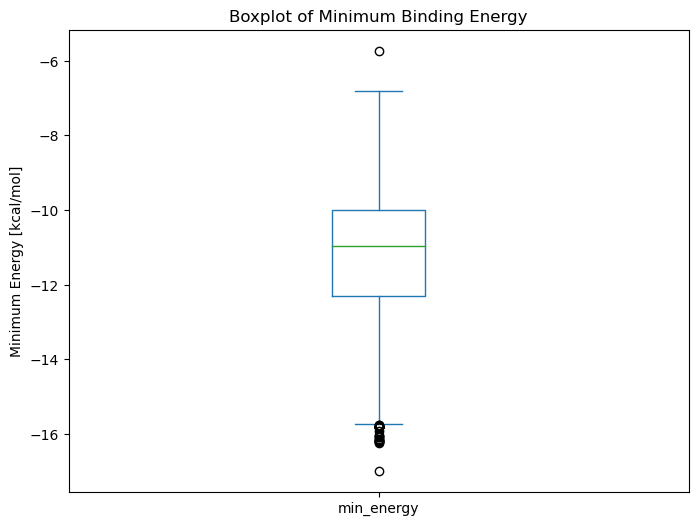

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
plt.figure(figsize=(8, 6))
df_ai_docked['min_energy'].plot(kind='box', rot=0)
plt.title('Boxplot of Minimum Binding Energy')
plt.ylabel('Minimum Energy [kcal/mol]')
plt.savefig("plots/min_energy_boxplot.png")

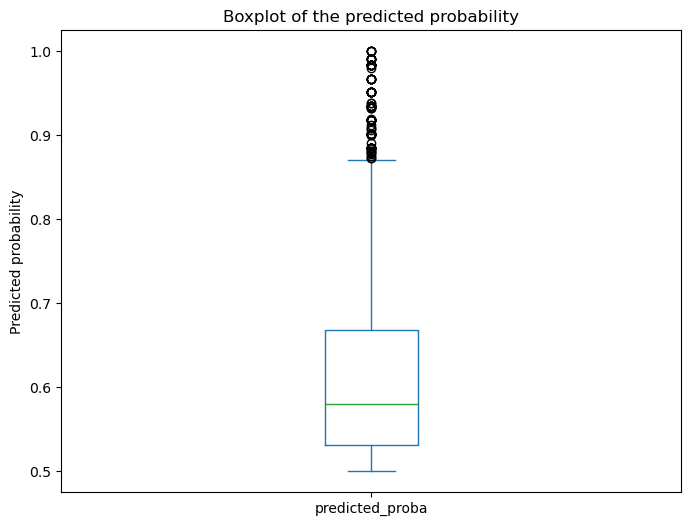

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
plt.figure(figsize=(8, 6))
df_ai_docked['predicted_proba'].plot(kind='box', rot=0)
plt.title('Boxplot of the predicted probability')
plt.ylabel('Predicted probability')
plt.savefig("plots/predicted probability.png")

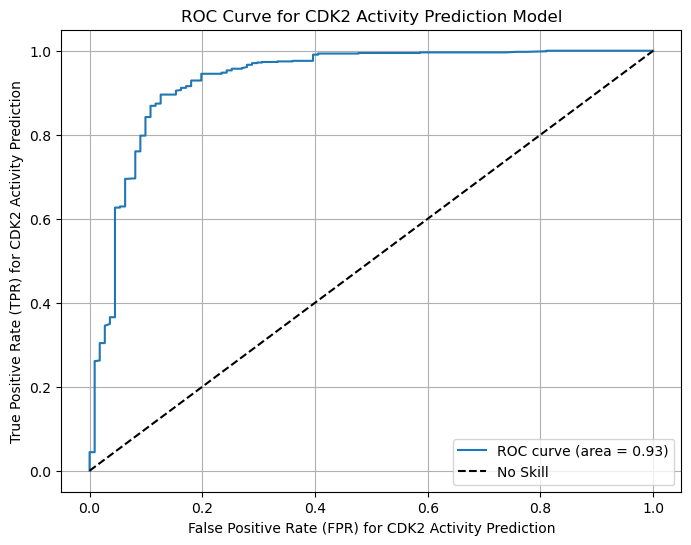

In [74]:
from sklearn.metrics import roc_curve, auc

# Assuming you have X_test and y_test defined

# Get the predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Import libraries for plotting
import matplotlib.pyplot as plt

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate (FPR) for CDK2 Activity Prediction')
plt.ylabel('True Positive Rate (TPR) for CDK2 Activity Prediction')
plt.title('ROC Curve for CDK2 Activity Prediction Model')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('cdk2_activity_prediction_roc_curve.png')



In [75]:
102/2856

0.03571428571428571